In [19]:
from pathlib import Path
import requests
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [ ]:
!rm -r imports
!rm -r images

# Import Files and Dependencies

In [ ]:
# useful files
files = {
    "images.zip":"https://github.com/Q-b1t/nst_demo_resources/raw/main/images/images.zip",
}
# create the import directory
imports_path = Path("imports")
imports_path.mkdir(exist_ok=True,parents=True)
paths = dict()

# import the files
for f,raw in files.items():
  new_path = imports_path / f
  req = requests.get(raw)
  with open(new_path,"wb") as fl:
    fl.write(req.content)
    print(f"File {raw} written to {new_path},")
    paths[f] = new_path

File https://github.com/Q-b1t/nst_demo_resources/raw/main/images/images.zip written to imports/images.zip,


## Unzip Sample Transfer Learning Images

In [ ]:
!mv imports/images.zip .
!unzip images.zip
!rm images.zip

Archive:  images.zip
   creating: images/
   creating: images/style/
  inflating: images/style/1200px-The_Fighting_Temeraire,_JMW_Turner,_National_Gallery.jpg  
  inflating: images/style/starry-night-over-the-rhone-5.jpg  
  inflating: images/style/ou_nous_allons.jpg  
  inflating: images/style/Giotto-Di-Bondone-The-Ascension.jpg  
  inflating: images/style/fenmeno-de-ingravidez.jpg  
   creating: images/content/
  inflating: images/content/SECRETOS-CATEDRAL-METROPOLITANA-CDMX-2.jpg  
  inflating: images/content/_129303416_gettyimages-992816562-1.jpg  
  inflating: images/content/b23764853d02ad4c25e0780c2cd6aa52--volcano-los.jpg  
  inflating: images/content/f.elconfidencial.com_original_dae_7b7_861_dae7b7861c3285b03b9f6555878c8c53.jpg  
  inflating: images/content/P1011143.jpg  


In [ ]:
# get the image paths as a list
image_path = Path("images")
style_path = image_path / "style"
content_path = image_path / "content"

style_images = list(style_path.glob("*.jpg"))
content_images = list(content_path.glob("*.jpg"))

In [ ]:
style_images,content_images

([PosixPath('images/style/starry-night-over-the-rhone-5.jpg'),
  PosixPath('images/style/fenmeno-de-ingravidez.jpg'),
  PosixPath('images/style/1200px-The_Fighting_Temeraire,_JMW_Turner,_National_Gallery.jpg'),
  PosixPath('images/style/ou_nous_allons.jpg'),
  PosixPath('images/style/Giotto-Di-Bondone-The-Ascension.jpg')],
 [PosixPath('images/content/b23764853d02ad4c25e0780c2cd6aa52--volcano-los.jpg'),
  PosixPath('images/content/_129303416_gettyimages-992816562-1.jpg'),
  PosixPath('images/content/SECRETOS-CATEDRAL-METROPOLITANA-CDMX-2.jpg'),
  PosixPath('images/content/f.elconfidencial.com_original_dae_7b7_861_dae7b7861c3285b03b9f6555878c8c53.jpg'),
  PosixPath('images/content/P1011143.jpg')])

# Get Two Sample Random Images

In [ ]:
style_image = random.choice(style_images)
content_image = random.choice(content_images)

(-0.5, 419.5, 631.5, -0.5)

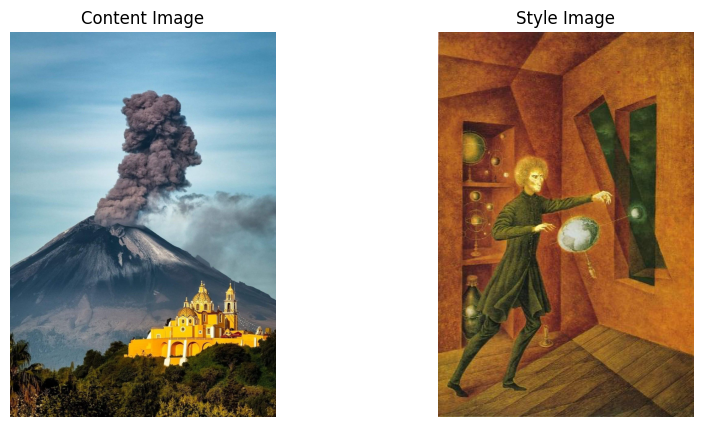

In [ ]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.title("Content Image")
plt.imshow(plt.imread(content_image))
plt.axis(False)
plt.subplot(1,2,2)
plt.title("Style Image")
plt.imshow(plt.imread(style_image))
plt.axis(False)

In [2]:
import numpy as np
import tensorflow as tf


2024-10-17 11:13:01.282146: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-17 11:13:01.294176: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-17 11:13:01.306967: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-17 11:13:01.310798: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-17 11:13:01.319258: I tensorflow/core/platform/cpu_feature_guar

# Define cost functions for style and content

In [1]:
# compute the gram matrix of the features
def gram_matrix(x):
  #x = tf.convert_to_tensor(x, tf.int32)
  x = tf.transpose(x,perm = (2,0,1))
  features = tf.reshape(x,(tf.shape(x)[0],-1))
  gram = tf.matmul(features,tf.transpose(features))
  return gram

# compute the style cost function
def style_cost_function(style_image,generated_image):
  S = gram_matrix(style_image)
  C = gram_matrix(generated_image)
  channels = 3
  size = img_nrows * img_ncols
  return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

def content_cost_function(base_image,generated_image):
  return tf.reduce_sum(tf.square(tf.subtract(generated_image,base_image)))

# Instance a Pretrained CNN

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [4]:
pretrained_vgg_model = VGG19(include_top = False, weights="imagenet")

I0000 00:00:1729159987.059448     793 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-17 11:13:07.089361: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
pretrained_vgg_model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

We proceed to extract some useful metadata such as the each layers name and its associated output tensor.

In [6]:
# extract the layers' name (for reference only)
model_layers = [layer.name for layer in pretrained_vgg_model.layers]
model_layers

['input_layer',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [7]:
# create a dictionary that maps the layers name to each feature extractor
model_outputs = {layer.name : layer.output for layer in pretrained_vgg_model.layers}

In [8]:
# feature extractor
feature_extractor = Model(inputs=pretrained_vgg_model.inputs, outputs=model_outputs)

# Neural Style Transfer Setup

In [9]:
# define the style layers
style_layers = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
    ]
# define the content layer
content_layer = "block5_conv2"

In [10]:
# define the style and content weights
content_weight = 2.5e-8
style_weight = 1.0e-6

In [11]:
def loss_function(combination_image, base_image, style_reference_image):
  # 1. Combine all the images in the same tensioner.
  input_tensor = tf.concat(
      [base_image, style_reference_image, combination_image], axis=0
  )

  # 2. Get the values in all the layers for the three images.
  features = feature_extractor(input_tensor)

  #3. Inicializar the loss

  loss = tf.zeros(shape=())

  # 4. Extract the content layers + content loss
  layer_features = features[content_layer]
  base_image_features = layer_features[0, :, :, :]
  combination_features = layer_features[2, :, :, :]

  loss = loss + content_weight * content_cost_function(
      base_image_features, combination_features
  )
  # 5. Extraer the style layers + style loss
  for layer_name in style_layers:
      layer_features = features[layer_name]
      style_reference_features = layer_features[1, :, :, :]
      combination_features = layer_features[2, :, :, :]
      sl = style_cost_function(style_reference_features, combination_features)
      loss += (style_weight / len(style_layers)) * sl

  return loss

In [12]:
@tf.function
def compute_loss_and_grads(generated_image, base_image, style_image):
    with tf.GradientTape() as tape:
        loss = loss_function(generated_image, base_image, style_image)
    grads = tape.gradient(loss, generated_image)
    return loss, grads

In [13]:
"""
def preprocess_image(image_path):
  # load the image into a tensot
  img = load_img(image_path, target_size=(img_nrows, img_ncols))
  # turn the image into a numpy array
  img = img_to_array(img)
  # add a batch dimention
  img = np.expand_dims(img, axis=0)
  # preprocess according to the vgg model's specification
  img = preprocess_input(img)
  return tf.convert_to_tensor(img)

"""


def preprocess_image(img):
  # load the image into a tensot
  img = img.resize((img_ncols,img_nrows))
  # turn the image into a numpy array
  img = img_to_array(img)
  # add a batch dimention
  img = np.expand_dims(img, axis=0)
  # preprocess according to the vgg model's specification
  img = preprocess_input(img)
  return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Cconert to array
    x = x.reshape((img_nrows, img_ncols, 3))
    # mean = 0
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # convert to rgb
    x = x[:, :, ::-1]
    # normalize
    x = np.clip(x, 0, 255).astype("uint8")
    return x


In [14]:
# store the loss curve values
loss_values = list()

In [21]:
from PIL import Image, ImageChops 
from diffusers.utils import load_image
## test 1 image 
image_path = "/home/muzzi/Image2image generation/Anomaly detection images/customer data/1 (402)_insulator_4.jpg"
style_path = "/home/muzzi/Image2image generation/edges.jpg"

content_image = load_image(image_path).convert('RGB')

style_image = load_image(style_path).convert('RGB')

base_pil_image = Image.open(image_path)
generated_pil_image = Image.open(image_path)
style_pil_image = Image.open(style_path)

width, height = base_pil_image.size


img_nrows = 400
img_ncols = int(width * img_nrows / height)

optimizer = SGD(
    ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_pil_image)
style_reference_image = preprocess_image(style_pil_image)
combination_image = tf.Variable(preprocess_image(generated_pil_image))

print(base_image.shape,style_reference_image.shape,combination_image.shape)

epochs = 4

for i in tqdm(range(epochs)):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print(f"ITERATION: {i} | LOSS: {loss:.3f}")
    loss_values.append(loss)

(1, 400, 216, 3) (1, 400, 216, 3) (1, 400, 216, 3)


 25%|██▌       | 1/4 [00:00<00:01,  1.85it/s]

ITERATION: 0 | LOSS: 43691.855


100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


Text(0.5, 0, 'Epochs')

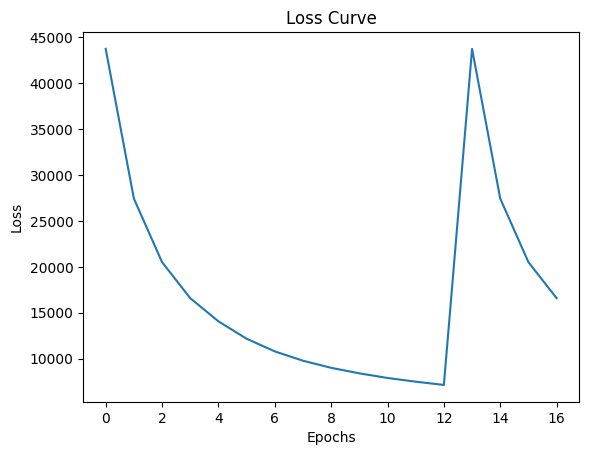

In [22]:
plt.figure()
plt.plot(loss_values)
plt.title("Loss Curve")
plt.ylabel("Loss")
plt.xlabel("Epochs")

In [23]:
combination_image.shape

TensorShape([1, 400, 216, 3])

In [24]:
generated_image_numpy = combination_image.numpy()
generated_image_numpy = deprocess_image(generated_image_numpy)
#generated_image_numpy = np.squeeze(generated_image_numpy,axis = 0)
generated_image_numpy.shape

(400, 216, 3)

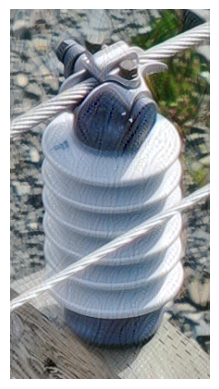

In [25]:
plt.imshow(generated_image_numpy)
plt.axis(False)
plt.savefig("generated_image.png")